In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk')
import scipy.stats as ss
import math

from scipy.integrate import simpson, trapezoid
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import gaussian_kde

import riskDualObserverShared as model
import tools as tools

In [2]:
import riskDualObserverShared as model
import tools as tools

2.0


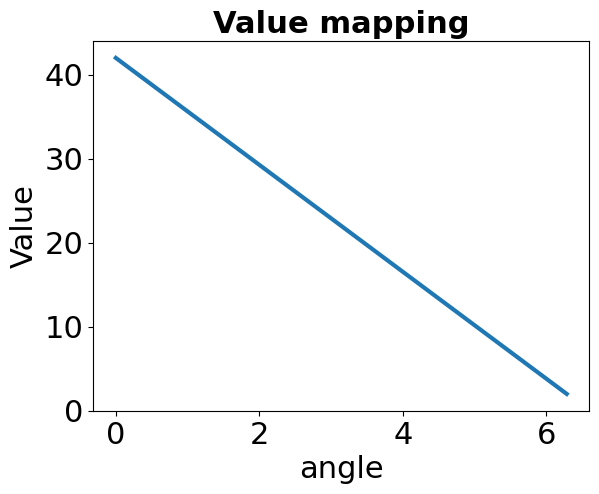

In [3]:
type = "linearDecrease"
line_frac = 0.0

plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, type, line_frac))
# plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, "cdf_prior", line_frac))
# plt.plot(tools.stim_ori_grid,(integrate.cumtrapz(tools.prior_ori(tools.stim_ori_grid), tools.stim_ori_grid, initial=0.0))*tools.factor_val+tools.min_val)

print(min(tools.value_function_ori(tools.stim_ori_grid, type, line_frac)))

plt.ylabel("Value")
plt.xlabel("angle")
plt.title("Value mapping", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

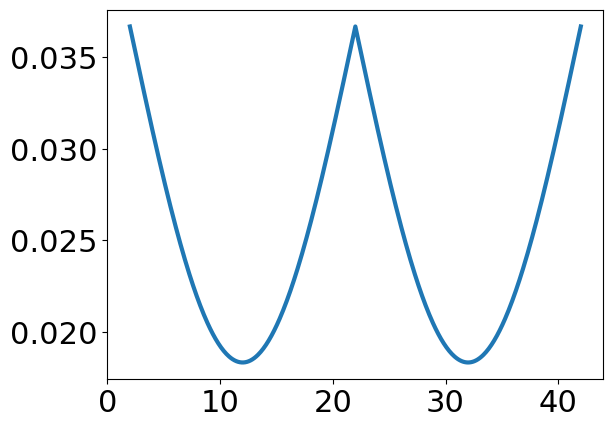

In [4]:
plt.plot(model.prior_val("linearIncrease")[0], model.prior_val("linearIncrease")[1])
# model.prior_val("inversePrior")[0]

(1, 501)

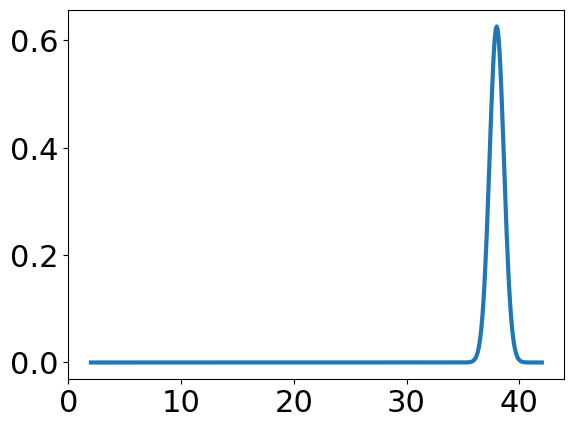

In [5]:

theta0 = 0.2*np.pi
kappa_s = 100
type = "linearDecrease"

bin_centers, ps = tools.ori_to_val_dist(model.stim_ori_grid, model.stimulus_ori_noise(theta0, kappa_s, model.stim_ori_grid), type, monotonic=True)


plt.plot(bin_centers, ps[0])

np.shape(bin_centers)
np.shape(ps)



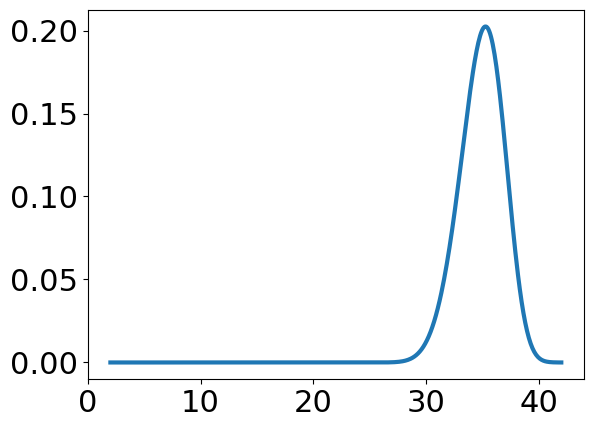

In [11]:
theta0 = 10/90*np.pi*np.pi
kappa_s = 1000
kappa_r = 32
type = "linearDecrease"

# rep_val_grid, p_mVal_given_Val0, p_mVal_given_Val = model.val_encoded(theta0, kappa_s, kappa_r, type)

rep_val_grid, stim_val_grid, p_value_est_given_val0 = model.value_bayesian_decoding(theta0, kappa_s, kappa_r, type)

# p_mOri_given_theta0, p_mOri_given_theta = model.MI_orientation_encoding(theta0, kappa_s, kappa_r)

# plt.plot(rep_val_grid, p_mVal_given_Val0[0])

plt.plot(stim_val_grid, p_value_est_given_val0[0])

# plt.plot(p_mOri_given_theta0[0])


70.0
30.239999999999995


array([[0.48456004]])

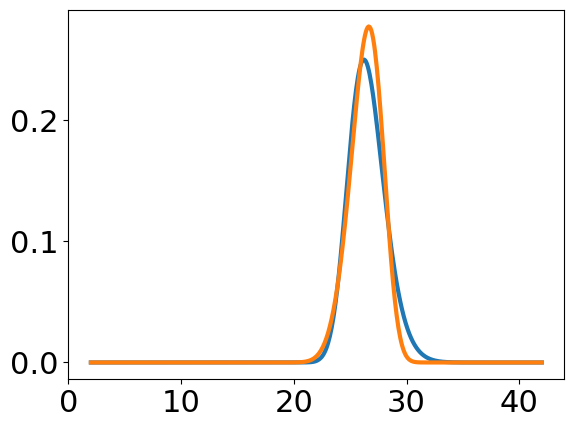

In [9]:
theta0 = 70./90.*np.pi
kappa_s = 10000
kappa_r = 32
type = "linearDecrease"
risk_prob = 0.75
theta1 = float(tools.inverse_monotonic(tools.value_function_ori(theta0, type)/risk_prob, type)) 

print(theta0*90/np.pi)
print(theta1*90/np.pi)

safe_value, safe_prob = model.safe_value_dist(theta0, kappa_s, kappa_r, type)
risky_value, risky_prob = model.risky_value_dist(theta1, kappa_s, kappa_r, risk_prob, type)

plt.plot(safe_value, safe_prob[0])
plt.plot(safe_value, risky_prob[0])

p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
p_chose_risky

# tools.get_rnp(safe_value, risky_value)
# plt.plot(rep_val_grid, p_mVal_given_Val0[0])
# plt.plot(stim_val_grid, p_val_given_mVal[40])
# plt.plot(stim_val_grid, abs(trapezoid((p_mVal_given_Val0[:,np.newaxis,:]*p_val_given_mVal[np.newaxis, ...]),rep_val_grid,axis = 2)[0]))
# plt.plot(stim_val_grid, p_value_est_given_val0[0])

# Uncovering risk attitudes

# Comaparing two models - Both safe and risky option with same noise type

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk')
import scipy.stats as ss
import math

from scipy.integrate import simpson, trapezoid
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import gaussian_kde

import riskDualObserverShared as model
import tools as tools

In [4]:
def rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, rep_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)

        # plt.plot(safe_value, safe_prob[0])
        # plt.plot(safe_value, risky_prob[0])
        # plt.plot(safe_value, risky_prob[-1])
        # plt.show()

        # print("safeval", safeVal)
        # print("val_ra", val_range)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        print(p_chose_risky[0,::2])
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp



safe angle -  1.0
[0.29505505 0.27959952 0.26672698 0.25673204 0.24981381 0.24607032
 0.24549903 0.24800299 0.25340164 0.26144494]
-0.42129916355640784
safe angle -  4.115675675675676
[0.2773027  0.2735243  0.27737482 0.28820405 0.30513646 0.32715936
 0.35320376 0.38221199 0.41318893 0.44523674]
0.6019192772146823
safe angle -  7.231351351351352
[0.2374809  0.25823529 0.28650552 0.32064616 0.35911203 0.40050905
 0.44361357 0.48737227 0.53089238 0.57342892]
0.7179206674576313
safe angle -  10.347027027027028
[0.2036359  0.23941691 0.28077509 0.32636637 0.37498146 0.42550402
 0.47688784 0.52815405 0.57840324 0.62683553]
0.7450364721283638
safe angle -  13.462702702702705
[0.17466299 0.21715964 0.26524926 0.31793345 0.37408276 0.43244017
 0.49167114 0.55043874 0.60748506 0.6617043 ]
0.7501113043836222
safe angle -  16.578378378378382
[0.14993965 0.19366063 0.24386191 0.29969269 0.35994098 0.42310721
 0.48752159 0.55148079 0.61338182 0.6718348 ]
0.7506938747795052
safe angle -  19.69405405

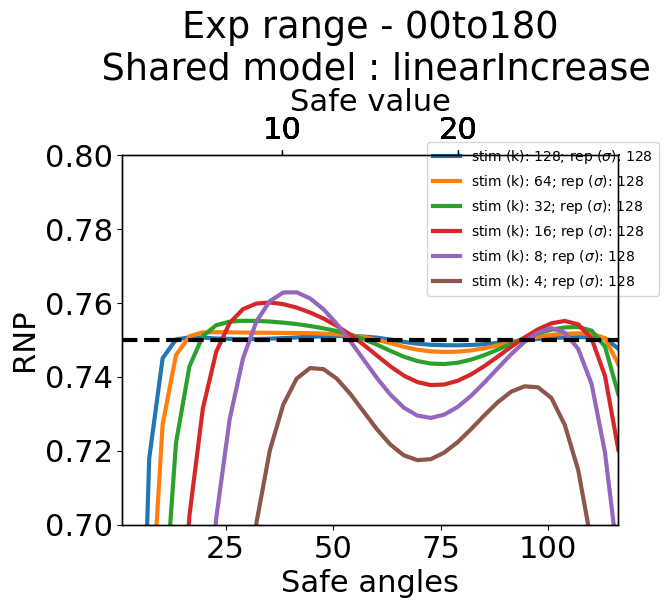

In [5]:
# setting parameters
experimentEffects = tools.experimentRange #"00to45"
risk_prob = 0.75
type = "linearIncrease" 

# changeable parameters
# stim_list = [10000]
# rep_list = [64, 32, 16, 8, 4]
# High stim noise
stim_list = [128, 64, 32, 16, 8, 4]
rep_list = [128]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for stim_noise in stim_list:
    for rep_noise in rep_list:

        safe_angles, safeVals, rnp = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
        ax1.set_ylim(0.7, 0.8)
        ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

        text = "stim (k): "+ str(stim_noise)+"; rep ($\sigma$): "+str(rep_noise)
        ax1.plot(safe_angles[:]*90./np.pi, rnp[:], label = text)


        ax2 = ax1.twiny()
        if (type=="prior" or type=="curvedPrior" or type=="linearDecrease"):
            ax2.set_xlim(max(safeVals), min(safe_angles))

        ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

ax1.axhline(risk_prob, c='k', ls='--')
ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

ax2.set_xlabel("Safe value")
ax1.set_xlabel("Safe angles")
ax1.set_ylabel("RNP")
ax1.set_title("Exp range - " + tools.experimentRange + "\n Shared model : " + type) 


plt.savefig('/Users/sbedi/Downloads/sharefig.png',dpi=300, bbox_inches = "tight")